Welcome to the EPISOL Colab Playground!



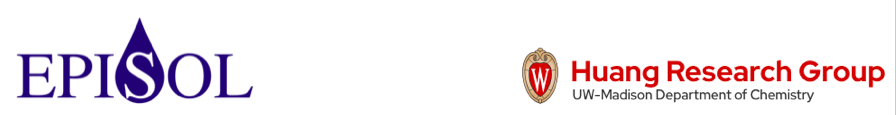

The 3D reference interaction site model (3DRISM) provides an efficient grid-based solvation model to compute the structural and thermodynamic properties of biomolecules in aqueous solutions, in this notebook we will walk through a high-throughput calculation on the solvation free energy of a test set of small molecules. We will compare our 3DRISM results to those of experimentally and computationally (FEP) determined free energies.   

* **goals**:
  * Generate the coordinate and topology files for our test set using RDKit and openFF
  * Perform high-throughput 3DRISM calculations to determine solvation free energy of 100 molecules in the test set
  * Be able to perform similar calculations on your own molecules
    * use the colab-notebook to download and run calculations on your own molecules

In [ ]:
#@title ##Download and Install Episol
#@markdown ($\approx 2$min) Stable as of 07/01/25 eprism v1.2.6
%%capture
import subprocess
import pandas as pd
import matplotlib.pyplot as plt
#%cd ../home/
%cd $HOME/
%mkdir episol
%cd episol
!wget https://github.com/EPISOLrelease/EPISOL/raw/refs/heads/main/src/fftw/fftw-3.3.8.tar.gz
!echo "+++++++++++++++++++"
!echo "downloaded fftw files"
!echo "+++++++++++++++++++"
!tar -xzf fftw-3.3.8.tar.gz
%cd fftw-3.3.8/
#!./configure --prefix=/home/fftw-3.3.8
!./configure --prefix=$HOME/episol/fftw-3.3.8
!make
!make install
%cd ../
!wget https://github.com/EPISOLrelease/EPISOL/raw/refs/heads/main/src/kernel/release.tar.gz
!echo "+++++++++++++++++++"
!echo "downloaded Episol files"
!echo "+++++++++++++++++++"
!tar -xzf release.tar.gz
%cd release/
#!./configure --with-fftw=/home/fftw-3.3.8
!./configure --with-fftw=$HOME/episol/fftw-3.3.8
!make
!make install
#%cd /content
########################### WRAPEPR
import subprocess
import os
import threading
import pandas as pd
import matplotlib.pyplot as plt
!pip install episol


In [ ]:
%%capture

#@title Install some python packages for topology generation
#@markdown ($\approx$4min)

#@markdown This will prompt a restart in our colab session, this is necessary, just keep moving

#@markdown (if you are using the notebook offline this wont be necessary, as presumably you'll have your own forcefield to generate topologies)
########################################
#        FOR COLAB USERS ONLY          #
#---------------------------------------#
# if you are running locally you dont need
# condacolab. Just use your local conda dist
########################################
!pip install -q condacolab
import condacolab
condacolab.install()
########################################
#!conda update conda
#!conda install --yes -c conda-forge  python=3.11 numpy=1.26.4 openmm pdbfixer parmed mdanalysis py3dmol rdkit openff-toolkit
#!conda install -y -c conda-forge numpy=1.26.4 openmm=8.3.1 python={PYTHON_VERSION} pdbfixer=1.11 parmed=4.3.0 mdanalysis=2.9.0 py3dmol=2.5.2 rdkit=2025.03.5 openff-toolkit=0.17.0 libgcc
!conda install -y -c conda-forge python=3.12 numpy=1.26.4 openmm=8.3.1 pdbfixer=1.11 parmed=4.3.0 mdanalysis=2.9.0 py3dmol=2.5.2 rdkit=2025.03.5 openff-toolkit=0.17.0 torchvision
#openmm pdbfixer parmed mdanalysis py3dmol rdkitconda install libgcc

In [ ]:
# FIX IMPORTER ERROR
!python -m ensurepip --upgrade
!pip3 install episol
!python3.12 -m pip install --upgrade setuptools

Looking in links: /tmp/tmp14g4fd4o


In [ ]:
#@title import our download packages
%%capture
import py3Dmol

def MolTo3DView(mol, size=(300, 300), style="stick", surface=False, opacity=0.5):
    """
    https://birdlet.github.io/2019/10/02/py3dmol_example/
    Draw molecule in 3D

    Args:
    ----
        mol: rdMol, molecule to show
        size: tuple(int, int), canvas size
        style: str, type of drawing molecule
               style can be 'line', 'stick', 'sphere', 'carton'
        surface, bool, display SAS
        opacity, float, opacity of surface, range 0.0-1.0
    Return:
    ----
        viewer: py3Dmol.view, a class for constructing embedded 3Dmol.js views in ipython notebooks.
    """
    assert style in ('line', 'stick', 'sphere', 'carton')
    mblock = Chem.MolToMolBlock(mol)
    viewer = py3Dmol.view(width=size[0], height=size[1])
    viewer.addModel(mblock, 'mol')
    viewer.setStyle({style:{}})
    if surface:
        viewer.addSurface(py3Dmol.SAS, {'opacity': opacity})
    viewer.zoomTo()
    return viewer
def smi2conf(smiles):
    '''Convert SMILES to rdkit.Mol with 3D coordinates'''
    mol = Chem.MolFromSmiles(smiles)
    if mol is not None:
        mol = Chem.AddHs(mol)
        AllChem.EmbedMolecule(mol)
        AllChem.MMFFOptimizeMolecule(mol, maxIters=200)
        return mol
    else:
        return None
#free_energy("EXP")
!python -m ensurepip --upgrade # since we are using python 3.12 some pkg utils are now obsolete
# after conda-initiate restart colab resets pip
import matplotlib.pyplot as plt
import openmm as mm
from   openmm import app
from   openmm.unit import *
import py3Dmol as pymol
import MDAnalysis as md
import parmed as chem
from openff.toolkit.topology import Molecule, Topology
import numpy as np
from MDAnalysis.transformations import center_in_box
from episol import epipy
from rdkit import Chem
from rdkit.Chem import AllChem
from openff.toolkit.topology import Molecule
from openff.toolkit.utils import get_data_file_path
from openff.toolkit.typing.engines.smirnoff import ForceField
from openff.interchange import Interchange
# FIX IMPORTER ERROR
!python -m ensurepip --upgrade
!pip3 install episol
!python3.12 -m pip install --upgrade setuptools
%cd /content/

#**Walk Through Calculation:**

* for this tutorial we will look at the solvation free energy of small molecules using FreeSolv Database
* lets download our files

In [ ]:
!wget https://github.com/MobleyLab/FreeSolv/raw/refs/heads/master/database.txt

--2025-09-08 00:02:23--  https://github.com/MobleyLab/FreeSolv/raw/refs/heads/master/database.txt
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/MobleyLab/FreeSolv/refs/heads/master/database.txt [following]
--2025-09-08 00:02:23--  https://raw.githubusercontent.com/MobleyLab/FreeSolv/refs/heads/master/database.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 144897 (142K) [text/plain]
Saving to: ‘database.txt’

database.txt        100%[===================>] 141.50K  --.-KB/s    in 0.03s   

2025-09-08 00:02:23 (4.45 MB/s) - ‘database.txt’ saved [144897/144897]



* now we will make a list containing allof the SMILES strings and their corresponding energies

In [ ]:
line_count = int()
experimental_values = []
calculated_values = []
smiles_list = []
names_list = []

with open('database.txt','r') as r:
  for line in r:
    line_count +=1
    if line_count > 3:
      tmp = line.split(';')
      try:
        names_list.append('_'.join(tmp[2].split()))
        smiles_list.append(tmp[1].strip())
        experimental_values.append(float(tmp[3].strip()))
        calculated_values.append(float(tmp[5].strip()))
      except Exception as exc:
        RuntimeWarning(exc)
smiles_list = np.array(smiles_list)
names_list = np.array(names_list)
experimental_values = np.array(experimental_values)
calculated_values = np.array(calculated_values)


* lets look at one of our (randomly picked) molecules

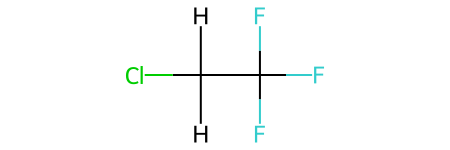

In [ ]:
rng = np.random.default_rng()
ind_to_extract = rng.integers(len(smiles_list),size=1)[0]
test = smiles_list[ind_to_extract]

mol = Chem.MolFromSmiles(test)
mol = Chem.rdmolops.AddHs(mol,addCoords=True)
mol

* we can see our molecule has totally non-physical geometry
* lets preform a simple geometry optimizationn step and view the output

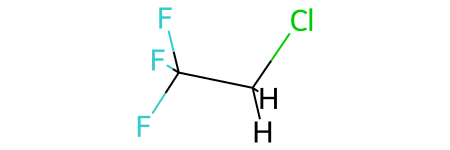

In [ ]:
AllChem.EmbedMolecule(mol)
AllChem.UFFOptimizeMolecule(mol)
mol

* much better
* now lets investigate solvation free energy of our molecule
* First we need to make our topology file
* thankfully using [openFF](https://openforcefield.org/force-fields/force-fields/) and [SMIRNOFF](https://docs.openforcefield.org/projects/toolkit/en/0.5.0/smirnoff.html) we can do this no problem!


In [ ]:
#!python -m ensurepip --upgrade
# use openFF..toolkit to accept rdkit object
from_rdmol = Molecule.from_rdkit(mol,allow_undefined_stereo=True)
topology = from_rdmol.to_topology()
# we will use openFF to assign SMIRNOFF parameters
sage = ForceField("openff-2.0.0.offxml")
interchange = Interchange.from_smirnoff(force_field=sage, topology=topology)
# just pick the first conformer
interchange.positions = from_rdmol.conformers[0]
#openmm_system = interchange.to_gromacs('out')
openmm_system = interchange.to_openmm()
#os.remove("out.top")
interchange.to_top("example.top")
tmp_u = md.Universe(mol)
coords = tmp_u.atoms.positions
# Buffer will be greater than 1nm (our default cutoff)
# here we set to 7A on each side, so at least 1.4 nm apart from the other side of
# the molecule
buffer = 5  # convert to A
#

box_x = np.ceil(np.abs(np.max((coords[:,0]))-np.min((coords[:,0])))+buffer)
box_y = np.ceil(np.abs(np.max((coords[:,1]))-np.min((coords[:,1])))+buffer)
box_z = np.ceil(np.abs(np.max((coords[:,2]))-np.min((coords[:,2])))+buffer)
tmp_u.dimensions = [box_x,box_y,box_z,90,90,90]
trans = center_in_box(tmp_u.atoms,center='geometry')

tmp_u.trajectory.add_transformations(trans)
tmp_u.atoms.write(f'fixed_example.gro') # have to write out structure file
## run 3DRISM
test = epipy(f'fixed_example.gro','example.top',gen_idc=True)
test.ndiis = 15
test.delvv = 0.5
test.r_c = 0.9 # cutoff at 0.9 nm instead of 1 nm (default)
test.err_tol = 1e-12
test.rism(resolution=0.5)
test.kernel(nt=2)
# We will use epipy's automatic unit conversion
# to specifiy our free energy units
test.free_energy()

/usr/local/lib/python3.12/site-packages/openff/amber_ff_ports/amber_ff_ports.py:8: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_filename
/usr/local/lib/python3.12/site-packages/MDAnalysis/coordinates/GRO.py:444: UserWarning: Supplied AtomGroup was missing the following attributes: resnames. These will be written with default values. Alternatively these can be supplied as keyword arguments.
  warnings.warn(


converted example.top to example.solute
generated idc-enabled solute file to: idc_example.solute
Calculation finished in 233 steps 
err_tol: 1e-12 actual: 9.38025e-13 


0.8673300582465404

* our output energy is in units of kJ/mol
* we can specify the units if need be by feeding our desired string to the function

In [ ]:
test.free_energy('kcal/mol')

0.20729685904554024

* lets see the energy _per_ molecuule

In [ ]:
test.free_energy('kcal')

1.2483416851722435e+23

* now lets run the first N molecules in the test set

In [ ]:
number_of_molecules_to_use = 50

rng = np.random.default_rng()
ind_to_extract = rng.integers(len(smiles_list),size=number_of_molecules_to_use)

#smiles_and_names = dict(zip(names_list[ind_to_extract],smiles_list[ind_to_extract]))
smiles_and_names = dict(zip(names_list[:number_of_molecules_to_use],smiles_list[:number_of_molecules_to_use]))


In [ ]:
len(smiles_and_names)

50

Run !
$\approx$ 5min for the first 50

In [ ]:
%%capture
#mols = [Chem.MolFromSmiles(x) for x in smiles_list[:5]]

def generate_topology_and_get_energy(smiles_list:list,keep_files=False):
  """
  This will automatically generate topology files for
  any small molecule SMILES-string.
  !!! Warning !!!
  We are using undefined stereochemistry
  -----------
  input: smiles_list -> list of SMILES strings
  output: energy_list -> list of solvation free energies whose
  index corresponds to the SMILES string input
  keep_files: boolean -> do you want to save ALL file generated
  or just keep the energy
  """
  import os
  out_energies = []
  try:
    for name in smiles_list:
      stage = "convert to rdkit mol"
      mol = Chem.MolFromSmiles(name)
      mol = Chem.rdmolops.AddHs(mol,addCoords=True)
      stage = "Add hydrogens and Geometry optimize "
      # geometry optimization step
      AllChem.EmbedMolecule(mol)
      AllChem.UFFOptimizeMolecule(mol)
      ##
      stage = "Pass to openFF "
      # use openFF..toolkit to accept rdkit object
      from_rdmol = Molecule.from_rdkit(mol,allow_undefined_stereo=True)
      topology = from_rdmol.to_topology()
      # we will use openFF to assign SMIRNOFF parameters
      stage = "Use smirnoff "
      sage = ForceField("openff-2.0.0.offxml")
      interchange = Interchange.from_smirnoff(force_field=sage, topology=topology)
      # just pick the first conformer
      interchange.positions = from_rdmol.conformers[0]
      #openmm_system = interchange.to_gromacs('out')
      openmm_system = interchange.to_openmm()
      #os.remove("out.top")
      stage = "Generate topology"
      interchange.to_top("out.top")
      tmp_u = md.Universe(mol)
      coords = tmp_u.atoms.positions
      # Buffer will be greater than 1nm (our default cutoff)
      # here we set to 7A on each side, so at least 1.4 nm apart from the other side of
      # the molecule
      buffer = 5  # convert to A
      #
      stage = "Center our molecule in a PBC"
      box_x = np.ceil(np.abs(np.max((coords[:,0]))-np.min((coords[:,0])))+buffer)
      box_y = np.ceil(np.abs(np.max((coords[:,1]))-np.min((coords[:,1])))+buffer)
      box_z = np.ceil(np.abs(np.max((coords[:,2]))-np.min((coords[:,2])))+buffer)
      tmp_u.dimensions = [box_x,box_y,box_z,90,90,90]
      trans = center_in_box(tmp_u.atoms,center='geometry')

      tmp_u.trajectory.add_transformations(trans)
      tmp_u.atoms.write(f'fixed_mol.gro') # have to write out structure file
      stage = "Start 3DRISM Calculation"
      ## run 3DRISM
      test = epipy(f'fixed_mol.gro','out.top',gen_idc=True)
      test.ndiis = 15
      test.delvv = 0.5
      test.r_c = 0.9 # cutoff at 0.9 nm instead of 1 nm (default)
      test.err_tol = 1e-12
      test.rism(resolution=0.5)
      test.kernel(nt=2)
      # We will use epipy's automatic unit conversion
      # to specifiy our free energy units
      out_energies.append(test.free_energy('kcal/mol'))
      # get rid of our calculation files
      # we dont really care about saving them
      # this way we dont have files piling up
      if not keep_files:
        os.remove("out.top")
        os.remove('fixed_mol_out.ts4s')
        os.remove('fixed_mol_out.log')
  except Exception as exc:
    print(f"molecule: {name} failed at stage {stage}")
    print(RuntimeError(exc))
  return out_energies
# Now we run
out_energies = generate_topology_and_get_energy(smiles_list=[smiles for smiles in smiles_and_names.values()])

* now, lets see our results

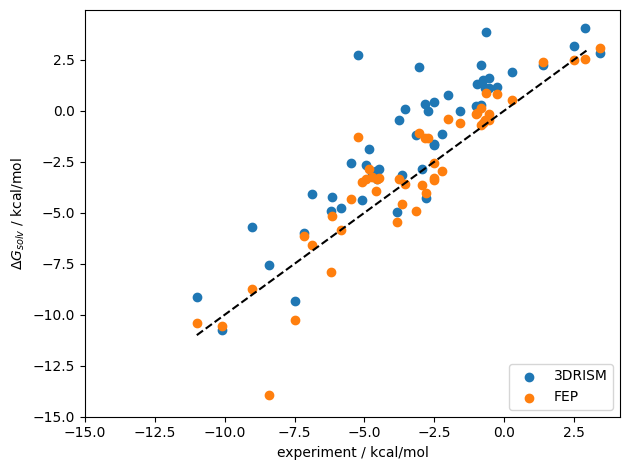

In [ ]:
fig,ax = plt.subplots()

#out_energies = np.copy(np.array(out_en))
dslice = len(out_energies)
ax.scatter(experimental_values[:dslice],out_energies,label='3DRISM')
ax.scatter(experimental_values[:dslice],calculated_values[:dslice],label='FEP')
#ax1.scatter(calculated_values[:dslice],out_energies)
#ax1.set_xlabel("experimental values")
ax.set_ylabel("$\\Delta G_{solv}$ / kcal/mol")
ax.set_xlabel("experiment / kcal/mol")
vv = np.arange(min(experimental_values[:dslice]),max(experimental_values[:dslice]))
ax.plot(vv,vv,'k--')
ax.set_ylim(-15,None)
ax.set_xlim(-15,None)
ax.legend(loc="lower right")
fig.tight_layout()

* feel free to use this notebook how you desire
* run the whole dataset or upload your own!
* we've included a section below where you can make your own molecule and run calculations
* get creative!

In [ ]:
smiles_string = "ClC=C=CCO" #@param {type: 'string'}
def smi2viewer(smi='CC=O'):
    try:
        conf = smi2conf(smi)
        return MolTo3DView(conf).show()
    except:
        return None
smi2viewer(smi=smiles_string)

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

Run 3DRISM

In [ ]:
print("your free energy of solvation is ",generate_topology_and_get_energy([smiles_string]),'kcal/mol')

/usr/local/lib/python3.12/site-packages/MDAnalysis/coordinates/GRO.py:444: UserWarning: Supplied AtomGroup was missing the following attributes: resnames. These will be written with default values. Alternatively these can be supplied as keyword arguments.
  warnings.warn(


converted out.top to out.solute
generated idc-enabled solute file to: idc_out.solute
Calculation finished in 267 steps 
err_tol: 1e-12 actual: 9.92814e-13 
your free energy of solvation is  [-5.00284805149884] kcal/mol
